In [1]:
import os
import numpy as np
from google.colab import drive
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf

In [2]:
# Periksa apakah TensorFlow menggunakan CPU
print("TensorFlow version:", tf.__version__)
print("Devices available:", tf.config.list_physical_devices())

TensorFlow version: 2.17.1
Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
# Mounting Google Drive in Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Direktori dataset skintone
skintone_directory = '/content/drive/MyDrive/smartfit/dataset/skintone'

In [5]:
# Buat generator untuk memuat data dari direktori
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalisasi pixel ke rentang [0, 1]
    validation_split=0.2  # 20% data untuk validation
)

In [6]:
# Generator untuk training data
train_generator = datagen.flow_from_directory(
    skintone_directory,
    target_size=(128, 128),  # Ukuran gambar lebih kecil untuk CPU
    batch_size=16,  # Kurangi batch size untuk efisiensi memori
    class_mode='sparse',  # Sparse untuk multi-class classification
    subset='training'
)

Found 26650 images belonging to 4 classes.


In [7]:
# Generator untuk validation data
val_generator = datagen.flow_from_directory(
    skintone_directory,
    target_size=(128, 128),
    batch_size=16,
    class_mode='sparse',
    subset='validation'
)

Found 6660 images belonging to 4 classes.


In [8]:
# Tampilkan informasi dataset
print("Training classes:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)

Training classes: {'dark': 0, 'light': 1, 'mid-dark': 2, 'mid-light': 3}
Number of training samples: 26650
Number of validation samples: 6660


In [9]:
# Bangun model CNN ringan
def build_light_cnn_model(num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),  # Mencegah overfitting
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Optimizer
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [10]:
# Bangun model
num_classes = len(train_generator.class_indices)
model = build_light_cnn_model(num_classes)

# Tampilkan summary model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,848,612 (7.05 MB)

 Trainable params: 1,848,612 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Callback untuk Early Stopping dan Model Checkpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # akurasi target
    restore_best_weights=True
)

In [12]:
# Latih model menggunakan generator (5 epoch)
history = model.fit(
    train_generator,
    steps_per_epoch=200,  # Batasi langkah per epoch
    epochs=5,  # 5 epoch
    validation_data=val_generator,
    validation_steps=50,  # Batasi langkah validasi
    callbacks=[early_stopping]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 768s 4s/step - accuracy: 0.5138 - loss: 1.0957 - val_accuracy: 0.6112 - val_loss: 0.8383
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.6732 - loss: 0.6919 - val_accuracy: 0.6687 - val_loss: 0.7233
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 505s 3s/step - accuracy: 0.7441 - loss: 0.5838 - val_accuracy: 0.7362 - val_loss: 0.6502
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.7481 - loss: 0.5689 - val_accuracy: 0.6562 - val_loss: 0.8544
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.7705 - loss: 0.5244 - val_accuracy: 0.7038 - val_loss: 0.6653


In [13]:
# Evaluasi model pada data validation
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

417/417 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - accuracy: 0.7271 - loss: 0.6586
Validation Loss: 0.663184642791748
Validation Accuracy: 72.01%


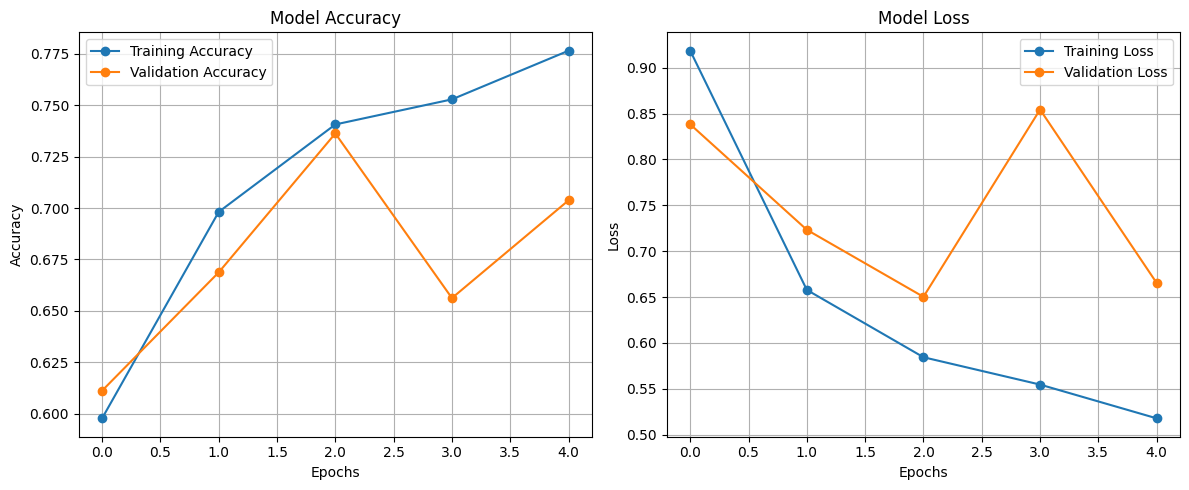

In [17]:
import matplotlib.pyplot as plt

# Fungsi untuk memvisualisasikan hasil training
def plot_training_history(history):
    # Plot akurasi
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Panggil fungsi dengan history dari pelatihan model
plot_training_history(history)


In [14]:
# Simpan model akhir
model.save('/content/drive/MyDrive/smartfit/models/skintone_model_final.h5')
print("Final model saved successfully!")

Final model saved successfully!
